In [25]:
#standard libs
import pandas as pd
import numpy as np
import os
import re


#tessract libs
import fitz
# for OCR using PyTesseract
import cv2                              # pre-processing images
import pytesseract                      # extracting text from images
import numpy as np
import matplotlib.pyplot as plt         # displaying output images
from PIL import Image
import regex
import io

## Function

Returns an dictionary containing the height of each page in pixels and the verticle pixel position at which the watermark starts.

In [15]:
def cut_watermark(SCANNED_FILE, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    for page in doc:
        if (page.number >= 1):
            png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            #if os.path.exists(png)==False:
            pix = page.get_pixmap(matrix=mat)
            print(png)
            pix.save(png)

            parsed[page.number]=None

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()
            #full length of image
            length=copied_image.shape[0]
            mask = np.zeros(original_image.shape, np.uint8)
            #i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 6')
                #print(i)
                if text=='':
                    continue
                print(x)
                print(y)
                print(text)
                
                print(regex.search(keyword,text.upper()))
                
                if regex.search(keyword, text.upper()) is not None:
                    print('found')
                    parsed[page.number]=(length,y)
                    plt.figure(figsize=(25, 15))
                    plt.imshow(cropped)
                    plt.show()
                    break
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                #i=i+1
                
    return parsed


## Set up variables
Note: the higher the zoom values, the more pixels and hight quality the png will be, and the slower tesseract will run. The kernel value (kval) requires tuning depending on the zoom. Too high and it does not separate things well.

In [22]:
# test
zoom_x = 3.0 # horizontal zoom 
zoom_y = 3.0 # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)
filepath="D:\\docs\\Masters\\Data\\AER_data\\1812515.pdf"
path="D:\\docs\\Masters\\Data\\AER_data\\"
kval=60 #kernel value
keywords="^THIS CONTENT DOWNLOADED FROM" #in all caps where ^ is regex and denoting that this is the start of the sentence

D:\docs\Masters\Data\AER_data\\1812514_page-1.png
216
1875
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 09:02:08 UTC
AII use subject to https://about.jstor.org/terms

<regex.Match object; span=(0, 28), match='THIS CONTENT DOWNLOADED FROM'>
found


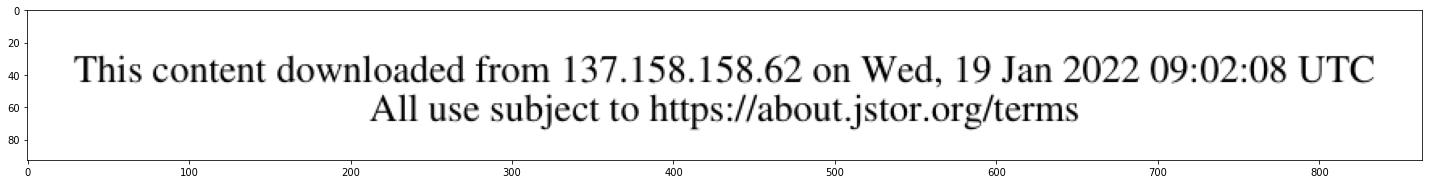

D:\docs\Masters\Data\AER_data\\1812514_page-2.png
216
1875
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 09:02:08 UTC
AII use subject to https://about.jstor.org/terms

<regex.Match object; span=(0, 28), match='THIS CONTENT DOWNLOADED FROM'>
found


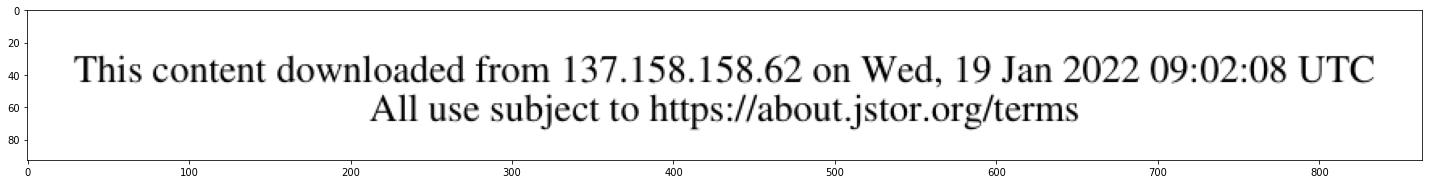

D:\docs\Masters\Data\AER_data\\1812514_page-3.png
216
1875
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 09:02:08 UTC
AII use subject to https://about.jstor.org/terms

<regex.Match object; span=(0, 28), match='THIS CONTENT DOWNLOADED FROM'>
found


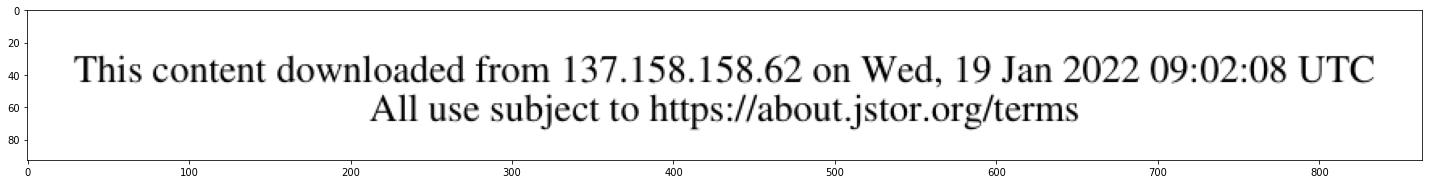

{1: (1968, 1875), 2: (1968, 1875), 3: (1968, 1875)}

In [21]:
cut_watermark(filepath, mat, path, kval, keywords)

## Loading in all data

In [2]:
JOURNALS= ['AER', 'JPE', 'ECTA', 'RES', 'QJE']
#read in all processed masterlists
All=pd.DataFrame()
for i in JOURNALS:
    All=pd.concat([pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\'+i+'_M_sco_du.xlsx'), All], ignore_index=True)

In [70]:
jpe=pd.read_csv('D:\\docs\\Masters\\Data\\jpe_refs2.csv')
path='D:\\docs\\Masters\\Data\\JPE_data\\JPE_shards\\'

In [93]:
jpe['fp']=path+jpe['pdf_url'].str.split('/').str[-1].str[:-1]
jpe['id']=jpe['pdf_url'].str.split('/').str[-1].str.split('_').str[0]
jpe['page']=jpe['pdf_url'].str.split('/').str[-1].str.split('-').str[-1].str.split('.').str[0].astype(int)

<AxesSubplot:xlabel='number of pages in document'>

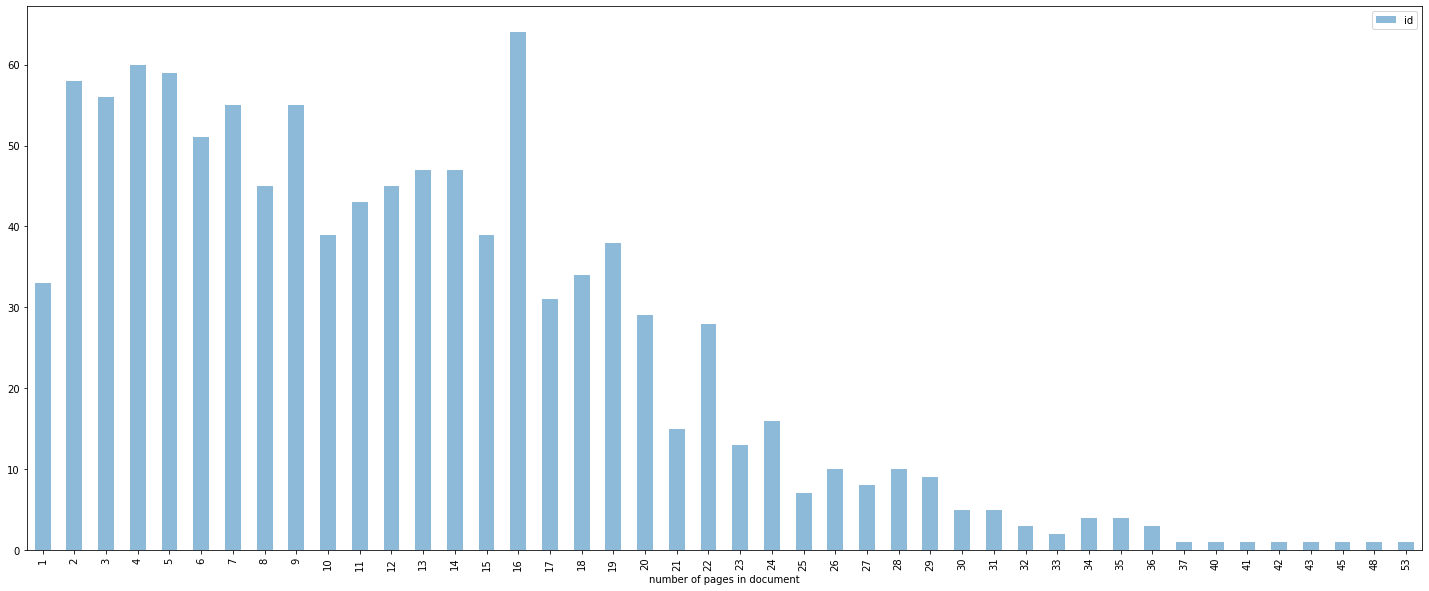

In [83]:

plt.rcParams["figure.figsize"] = (25, 10)
page_counts=pd.DataFrame(jpe['id'].value_counts())['id'].value_counts().sort_index()
page_counts.plot.bar(x='index', 
                  stacked=True, 
                  alpha=0.5, 
                  legend=True, 
                  xlabel='number of pages in document', 
                  width=0.5
                 )

In [154]:
plt.rcParams["figure.figsize"] = (25, 10)
page_counts=pd.DataFrame(jpe['year'].value_counts()).sort_index()
sum(page_counts[page_counts.index>1940]['year'])
sum(page_counts[page_counts.index>=1944]['year'])
#2451/748
#1037/456

10500

In [142]:
len(jpe['id'].unique())
ids=pd.DataFrame(jpe[['id','year']].value_counts()).sort_values('year', ascending=False)

In [123]:
jpe[['id', 'year']]

AttributeError: 'DataFrame' object has no attribute 'unique'

1825203
3
yes
1825510
1
3
yes


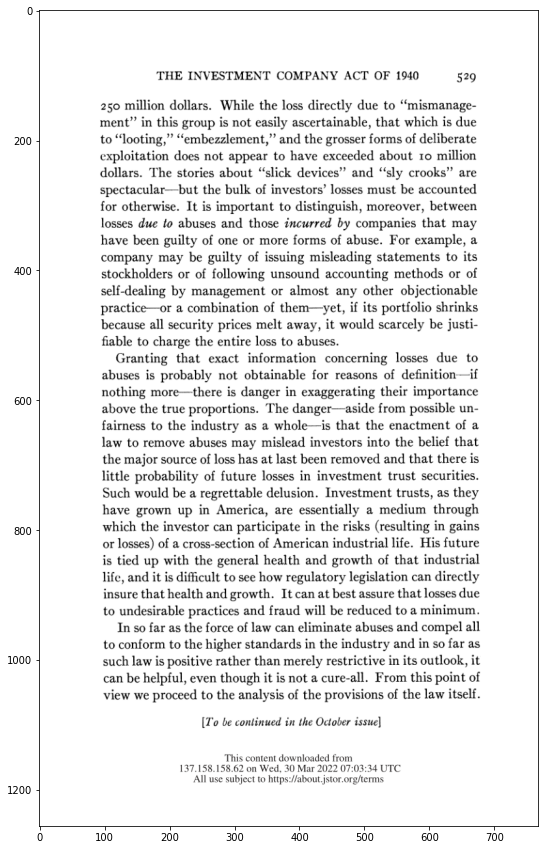

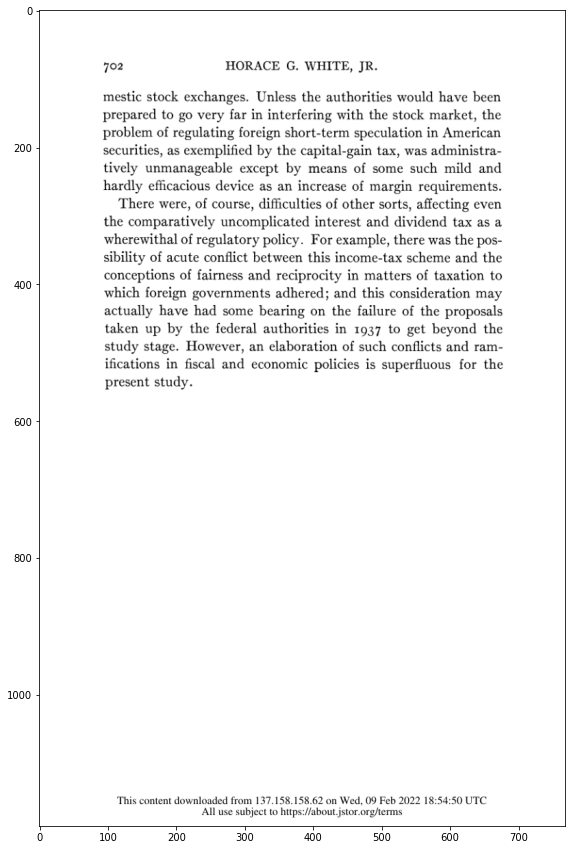

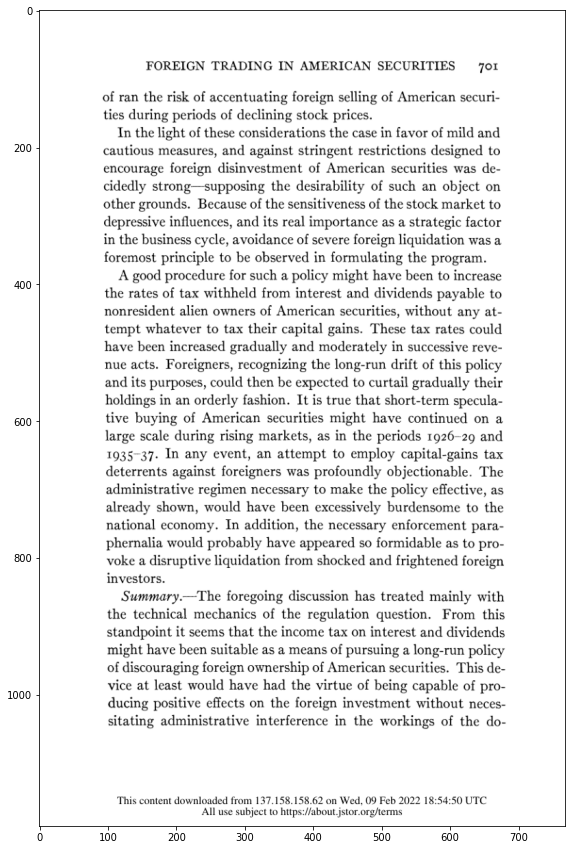

In [99]:
zoom_x = 2.0 # horizontal zoom 
zoom_y = 2.0 # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)
plt.ion()
plt.figure(figsize=(15, 10))
list=[None]*jpe.shape[0]
for j in ids.index[:2]:
    print(j)
    select=jpe[jpe['id']==j].sort_values(['page'], ascending=False)
    for i in select.index:
        pdf_file=fitz.open(jpe.loc[i,'fp'])
        page=pdf_file[0]
        rgb=page.get_pixmap(matrix=mat)
        pil_image=Image.open(io.BytesIO(rgb.tobytes()))
        plt.imshow(pil_image.convert('RGB'))
        answer=input()
        list.insert(i, 
                    {'pdf_url': jpe.loc[i,'pdf_url'],
                     'year': jpe.loc[i,'year'], 
                     'journal': 'JPE', 
                     'Answer': answer,
                     'id': jpe.loc[i,'pdf_url'].split('/')[-1].split('_')[0],
                     'page': jpe.loc[i,'pdf_url'].split('/')[-1].split('-')[-1].split('.')[0]
                    }
                   )
        if answer=='3':
            break

In [106]:
pd.DataFrame(list).to_csv('abc.csv')

,pdf_url,year,journal,Answer,id,page
0,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,1829883,0
1,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,1829883,1
2,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,1829883,2
3,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,1829883,3
4,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,1829883,4
5,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,829883,0
6,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,829883,1
7,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,829883,2
8,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,829883,3
9,'https://myawsbucket-1231.s3.eu-west-3.amazona...,1965,JPE,1,829883,4


In [ ]:
JOURNALS= ['AER', 'JPE', 'ECTA', 'RES', 'QJE']
#read in all processed masterlists
all_pages=pd.DataFrame()
for i in JOURNALS:
    all_pages=pd.concat([pd.read_csv(path+"\\"+i.lower()+"_refs_all.csv"),all_pages], ignore_index=True)
